In [1]:
import pickle
import os
import argparse
import time
import torch
from jax import random
import json
import datetime
from src.losses import sse_loss
from src.helper import compute_num_params, tree_random_normal_like
from src.models.fc import FC_NN
from src.sampling.predictive_samplers import sample_predictive, sample_hessian_predictive
from jax import numpy as jnp
import jax
from jax import flatten_util
import matplotlib.pyplot as plt
import tree_math as tm
import optax

In [2]:
def f(x):
    return jnp.sin(5 * x + 1) #+ jnp.cos(25 * x + 1) + jnp.exp(0.1 * x) + 5


In [3]:
model_key, data_key, noise_key, init_key, split_key = random.split(random.PRNGKey(42), 5)
input_dim = 1
output_dim = 1
n_batches = 50
N = 500
x_train = random.uniform(data_key, (N, input_dim), minval=0, maxval=1)
x_val = jnp.linspace(-1, 2, 100).reshape(-1, 1)
B = int(N / n_batches)
noise_std = 0.01
rho = 1 / noise_std**2
prior_cov = 2.5
# log_alpha, log_rho = jnp.log(alpha), jnp.log(rho)
y_train = f(x_train) + random.normal(noise_key, (N, input_dim)) * noise_std
y_train = y_train[:, :output_dim]

# model = FC_NN(output_dim, 15)
model = FC_NN(output_dim, 10, 2)
params = model.init(model_key, x_train[:B])
D = compute_num_params(params)


In [4]:
def mse_loss(preds, y):
    residual = preds - y
    return jnp.mean(residual**2)

def elbo(mu, sigma, key, prior_cov, n_params, x, y, n_samples=1):  
    # if n_samples > 1:
    eps = tree_random_normal_like(key, mu, n_samples)
    samples = jax.tree_map(lambda m, s, e: m + jax.nn.softplus(s) * e, mu, sigma, eps)
    preds = jax.vmap(model.apply, in_axes=(0, None))(samples, x)
    loglik = jax.vmap(mse_loss, in_axes=(0, None))(preds, y).mean()
    
    # else:
        # eps = tree_random_normal_like(key, mu)
        # samples = jax.tree_map(lambda m, s, e: m + jax.nn.softplus(s) * e, mu, sigma, eps)
        # preds = model.apply(samples, x)
        # loglik = mse_loss(preds, y)
    # logdet_prior = jax.tree_map(lambda x: jnp.ones_like(x), mu)
    # kl = 0
    logdet_pos = tm.Vector(jax.tree_map(lambda x: jnp.log(jax.nn.softplus(x)**2), sigma)).sum()
    logdet_prior = jnp.log(prior_cov**2) * n_params
    trace = 1/prior_cov**2 * tm.Vector(jax.tree_map(lambda x: x**2, sigma)).sum()
    mean = 1/prior_cov**2 * tm.Vector(jax.tree_map(lambda x: x**2, mu)).sum()
    kl = 0.5 * (logdet_pos - logdet_prior + trace + mean - n_params)
    loss = N/B * loglik.mean() + kl
    return loss, (loglik.mean(), kl)

In [5]:
lr = 1e-3
n_epochs = 2000
optim = optax.adam(lr)

mu = tree_random_normal_like(model_key, params)
sigma = tree_random_normal_like(model_key, params)
opt_state = optim.init((mu, sigma))


In [6]:
def make_step(mu, sigma, opt_state, key, x, y, n_samples=1):
        grad_fn = jax.value_and_grad(elbo, argnums=(0, 1), has_aux=True)
        loss, grads = grad_fn(mu, sigma, key, prior_cov, D, x, y, n_samples)
        (mu_updates, sigma_updates), opt_state = optim.update(grads, opt_state)
        mu = optax.apply_updates(mu, mu_updates)
        sigma = optax.apply_updates(sigma, sigma_updates)
        return loss, mu, sigma, opt_state
jit_make_step = jax.jit(make_step, static_argnames=("n_samples"))


In [7]:
losses = []
log_likelihoods = []
kls = []
mean_loss = []
mse_preds = []
# Training with Marginal Likelihood loss
print("Starting training...")
for epoch in range(n_epochs):
    start_time = time.time()
    train_key, split_key = random.split(split_key)
    batch_indices_shuffled = random.permutation(train_key, x_train.shape[0])
    for i in range(n_batches):
        train_key, split_key = random.split(split_key)
        x_batch = x_train[batch_indices_shuffled[i * B : (i + 1) * B]]
        y_batch = y_train[batch_indices_shuffled[i * B : (i + 1) * B]]
        loss, mu, sigma, opt_state = jit_make_step(
            mu, sigma, opt_state, train_key, x_batch, y_batch, 10
        )

        loss, (log_likelihood, kl) = loss
        losses.append(loss)
        log_likelihoods.append(log_likelihood.item())
        kls.append(kl.item())
    epoch_time = time.time() - start_time
    log_likelihood_epoch = jnp.mean(jnp.array(log_likelihoods[-B:]))
    epoch_loss = jnp.mean(jnp.array(losses[-B:]))
    epoch_kl = jnp.mean(jnp.array(kls[-B:]))
    print(
        f"epoch={epoch}, log likelihood ={log_likelihood_epoch:.2f}, loss ={epoch_loss:.2f}, kl ={epoch_kl:.2f}, time={epoch_time:.3f}s"
    )


Starting training...
epoch=0, log likelihood =25.62, loss =1044.97, kl =-236.22, time=3.380s
epoch=1, log likelihood =18.54, loss =690.24, kl =-236.88, time=0.221s
epoch=2, log likelihood =18.79, loss =702.23, kl =-237.50, time=0.218s
epoch=3, log likelihood =17.16, loss =619.81, kl =-238.06, time=0.216s
epoch=4, log likelihood =12.63, loss =393.09, kl =-238.63, time=0.216s
epoch=5, log likelihood =16.94, loss =607.58, kl =-239.23, time=0.215s
epoch=6, log likelihood =19.22, loss =721.03, kl =-239.75, time=0.215s
epoch=7, log likelihood =14.31, loss =475.08, kl =-240.39, time=0.215s
epoch=8, log likelihood =16.26, loss =571.89, kl =-241.03, time=0.214s
epoch=9, log likelihood =13.62, loss =439.17, kl =-241.66, time=0.216s
epoch=10, log likelihood =14.96, loss =505.87, kl =-242.34, time=0.211s
epoch=11, log likelihood =13.64, loss =438.90, kl =-242.96, time=0.210s
epoch=12, log likelihood =14.35, loss =474.14, kl =-243.55, time=0.210s
epoch=13, log likelihood =13.55, loss =433.33, kl =-

In [8]:
eps = tree_random_normal_like(model_key, mu, n_samples=10)
sample = jax.tree_map(lambda m, s, e: m + jax.nn.softplus(s) * e, mu, sigma, eps)

In [9]:
preds = jax.vmap(model.apply, in_axes=(0, None))(sample, x_val)


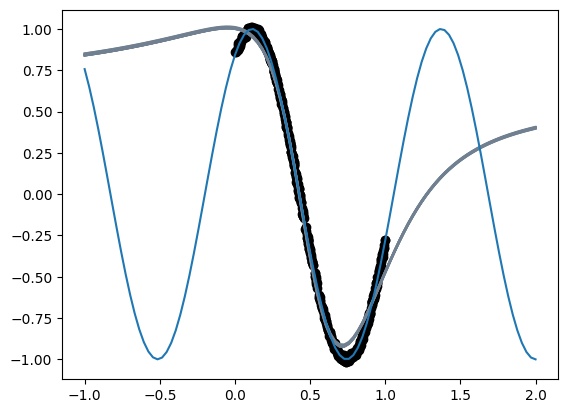

In [10]:
plt.plot(x_val.squeeze(), preds.squeeze().transpose(), label="Predictions", marker="None", color="slategray")
plt.plot(x_val, f(x_val), label="Predictions", marker="None")
plt.scatter(x_train, y_train, label="Training data", color="black")
